# Script to combine the quantum efficiency measurement data into a single ascii file for input to runReferenceFileConversion

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy import stats
from scipy.interpolate import interp1d
import os
import csv
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
mpl.rcParams['figure.facecolor'] = '1.'
mpl.rcParams['axes.formatter.useoffset'] = False

In [18]:
CHEOPS_SW = '/Users/futyand/CHEOPS/cheops_svn_v6/'

Read in the QE.txt file provided by Andrea Fortier to the SOC on 28th April 2020. This file was constructed using as input the following file provided by ESA:

https://svn.isdc.unige.ch/svn-cheops/06_cheopsim/software/CHEOPSim/tags/current/reference_file_generation/resources/QE_Apr_2020/QE_CCD47-20-13351-10-09_FM1-10042020.txt

The ESA data for the QE value vs wavelength has been interpolated linearly to a candence of 0.5 nm and extrapolated to cover the range from 330 to 1100 nm.

Text(0, 0.5, 'QE')

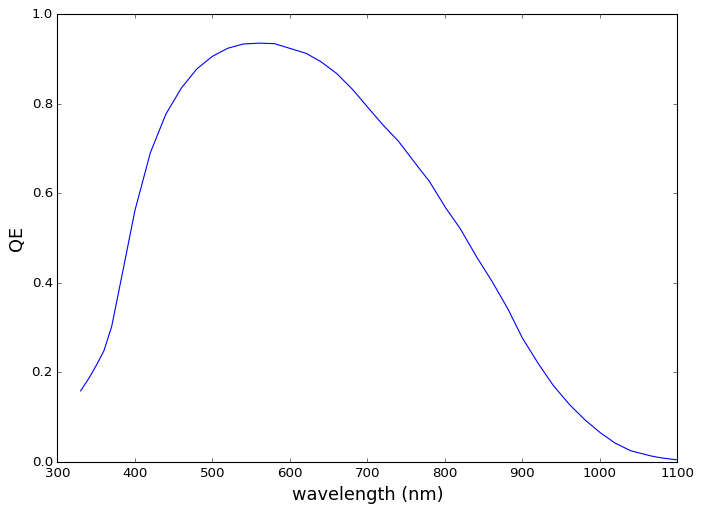

In [19]:
f = open(CHEOPS_SW+'CHEOPSim/reference_file_generation/resources/QE_Apr_2020/QE.txt', 'r')
lines = f.readlines()
f.close()
wavelength_fine = []
qe = []
for line in lines:
    p = line.split()
    wl = float(p[0])
    if round(wl) == wl: #ascii file is in steps of 0.5nm, but REF_APP_QE uses 1nm
        wavelength_fine.append(wl)
        qe.append(float(p[1]))

plt.figure(figsize=(10,7))
plt.plot(np.asfarray(wavelength_fine),np.asfarray(qe))
ax = plt.subplot(1,1,1)
ax.set_xlabel('wavelength (nm)', fontsize=16)
ax.set_ylabel('QE', fontsize=16)

Read in the QE error vs wavelength from the ESA file

Text(0, 0.5, 'QE Error')

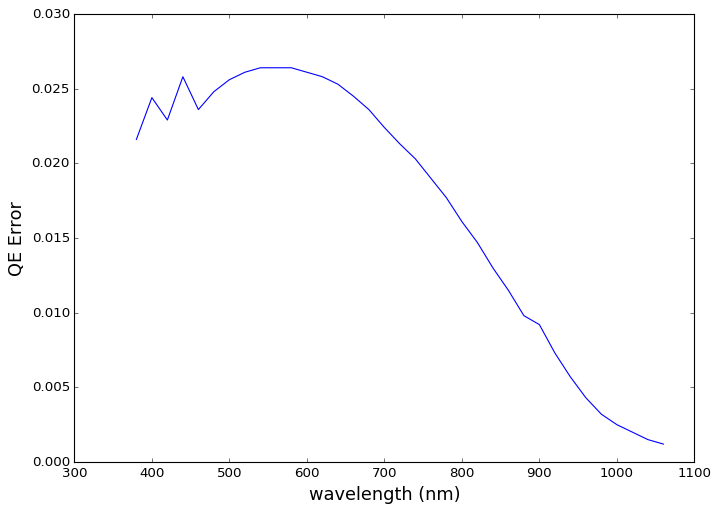

In [20]:
f = open(CHEOPS_SW+'CHEOPSim/reference_file_generation/resources/QE_Apr_2020/QE_CCD47-20-13351-10-09_FM1-10042020.txt', 'r')
lines = f.readlines()
f.close()
wavelength = []
err = []
for line in lines:
    if line[0].isdigit():
        p = line.split()
        wavelength.append(float(p[0]))
        err.append(float(p[3]))

plt.figure(figsize=(10,7))
plt.plot(np.asfarray(wavelength),np.asfarray(err))
ax = plt.subplot(1,1,1)
ax.set_xlabel('wavelength (nm)', fontsize=16)
ax.set_ylabel('QE Error', fontsize=16)

Read in the temperature sensitivity of the QE vs wavelength from the ESA file

[380.0, 400.0, 420.0, 440.0, 460.0, 480.0, 500.0, 520.0, 540.0, 560.0, 580.0, 600.0, 620.0, 640.0, 660.0, 680.0, 700.0, 720.0, 740.0, 760.0, 780.0, 800.0, 820.0, 840.0, 860.0, 880.0, 900.0, 920.0, 940.0, 960.0, 980.0, 1000.0, 1020.0, 1040.0, 1060.0]


Text(0, 0.5, 'QE Temperature sensitivity [ppm/mK]')

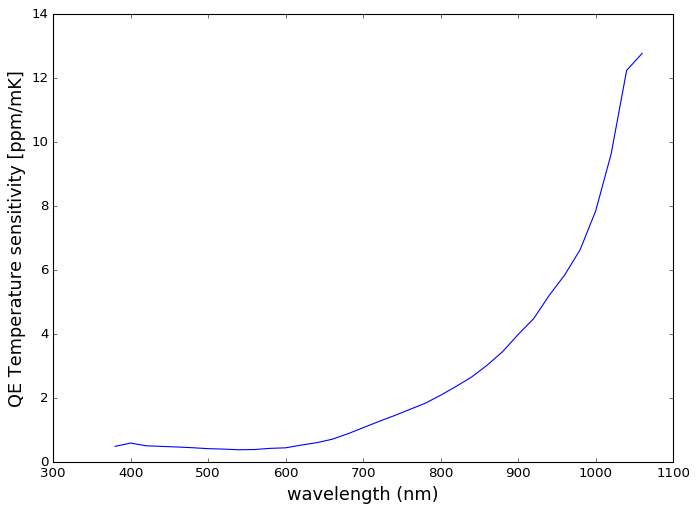

In [21]:
f = open(CHEOPS_SW+'CHEOPSim/reference_file_generation/resources/QE_Apr_2020/QE-Tsensitivity-11202-02-03-233K.txt', 'r')
lines = f.readlines()
f.close()
wavelength2 = []
temp_slope = []
for line in lines:
    if line[0].isdigit():
        p = line.split()
        wavelength2.append(float(p[0]))
        temp_slope.append(float(p[1]))

print(wavelength2)
plt.figure(figsize=(10,7))
plt.plot(np.asfarray(wavelength2),np.asfarray(temp_slope))
ax = plt.subplot(1,1,1)
ax.set_xlabel('wavelength (nm)', fontsize=16)
ax.set_ylabel('QE Temperature sensitivity [ppm/mK]', fontsize=16)
#plt.ylim(0,2)

Interpolate the QE error vs wavelength to a cadence of 1nm

Text(0, 0.5, 'QE Error')

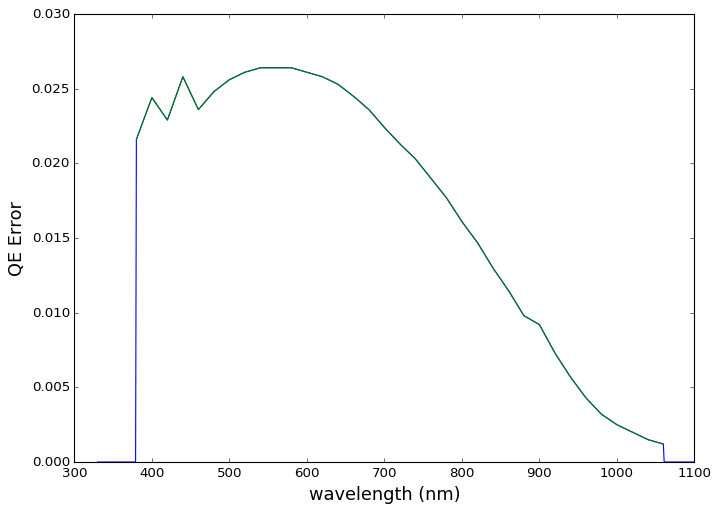

In [22]:
err_fine = []
count = 0
for wl in np.arange(330.,1101.):
    if wl<380. or wl>1060.:
        err_fine.append(0.)
    else:
        for i in range(len(wavelength)):
            if float(wavelength[i])<=wl:
                mu = (wl-wavelength[i-1])/(wavelength[i]-wavelength[i-1])
                err_fine.append(err[i-1]*(1.-mu)+err[i]*mu)
                break

plt.figure(figsize=(10,7))
plt.plot(np.asfarray(wavelength_fine),np.asfarray(err_fine))
plt.plot(np.asfarray(wavelength),np.asfarray(err))
ax = plt.subplot(1,1,1)
ax.set_xlabel('wavelength (nm)', fontsize=16)
ax.set_ylabel('QE Error', fontsize=16)

Interpolate the temperature sensitivity of the QE vs wavelength to a cadence of 0.5nm

Text(0, 0.5, 'QE Temperature sensitivity [ppm/mK]')

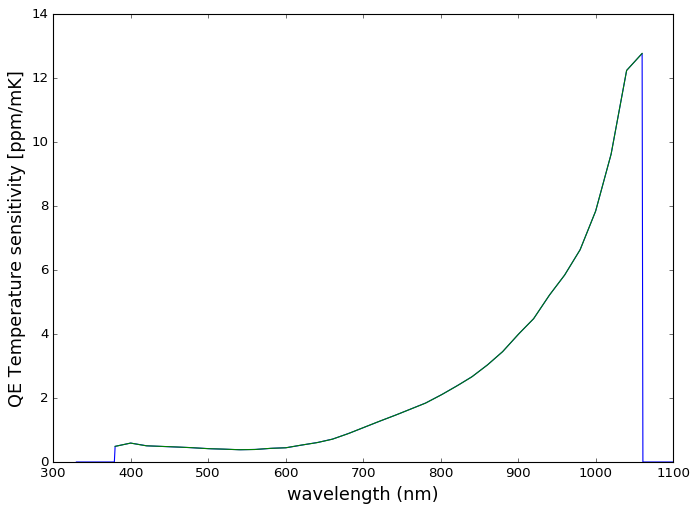

In [23]:
temp_slope_fine = []
for wl in np.arange(330.,1101.):
    if wl<380. or wl>1060.:
        temp_slope_fine.append(0.)
    else:
        for i in range(len(wavelength2)):
            if float(wavelength2[i])>=wl:
                mu = (wl-wavelength2[i-1])/(wavelength2[i]-wavelength2[i-1])
                temp_slope_fine.append(temp_slope[i-1]*(1.-mu)+temp_slope[i]*mu)
                break

plt.figure(figsize=(10,7))
plt.plot(np.asfarray(wavelength_fine),np.asfarray(temp_slope_fine))
plt.plot(np.asfarray(wavelength2),np.asfarray(temp_slope))
ax = plt.subplot(1,1,1)
ax.set_xlabel('wavelength (nm)', fontsize=16)
ax.set_ylabel('QE Temperature sensitivity [ppm/mK]', fontsize=16)

In [24]:
f = open(CHEOPS_SW+'CHEOPSim/reference_file_generation/resources/QE_Apr_2020/QE_data.txt', 'w')
writer = csv.writer(f, delimiter="\t")
writer.writerow(['# wavelength [nm]','QE (FM1)','QE 1sigma-error_if-used-for-FM2','sensitivity_[ppm/mK]'])
for i in range(len(wavelength_fine)):
    writer.writerow(["{:.1f}".format(wavelength_fine[i]),"{:.9f}".format(qe[i]),
                     "{:.5f}".format(err_fine[i]),"{:.9f}".format(temp_slope_fine[i])])
f.close()